In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from skmap.misc import find_files, GoogleSheet, ttprint
import warnings
import multiprocess as mp
import time
from scipy.special import expit, logit
import warnings
from sklearn.metrics import d2_tweedie_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
import joblib
import pickle
from sklearn.metrics import r2_score, mean_squared_error, make_scorer#, root_mean_squared_error
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
# from cubist import Cubist
from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path
from trees_rf import TreesRandomForestRegressor
from model_fit import read_features, cfi_calc, parameter_fine_tuning, calc_ccc, separate_data, rscfi 
from model_fit import accuracy_plot, plot_top_features, pdp_hexbin, plot_histogram, calc_metrics, accuracy_strata_plot, accuracy_plot_pred_space, calc_metrics_modified
import warnings
from sklearn.inspection import permutation_importance
warnings.filterwarnings('ignore')
import os
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import json
from datetime import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
from cmcrameri import cm
import math
from matplotlib.ticker import FuncFormatter  # Added
import geopandas as gpd

cmap = cm.batlow_r  
cmap.set_bad(color="#F8F8FF")


folder_path = '/mnt/ripley/global_soc/scikit-map/global-soil-mapping'
# prop_list = ['ocd', 'soc', 'bulk.density', 'ph.h2o' ,'coarse']
prop_list = ['ocd','ph.h2o']

transforms_dict = {
    'ocd': 'log1p',
    'ph.h2o': None
}
version = '20250204'
df = pd.read_parquet(f'{folder_path}/material/soil_pnts_organized_v{version}.pq')

In [2]:
# from trees_rf import cast_tree_rf

# kf = KFold(n_splits=10, shuffle=True, random_state=42)

# for prop in prop_list[1::]:
#     print(f'\n{prop}--------------------------------------------------------------')
#     space = transforms_dict[prop]
#     output_folder = folder_path+'/'+prop
#     os.makedirs(output_folder, exist_ok=True)
    
#     if space=='log1p':
#         df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
#         tgt = f'{prop}_log1p'
#     else:
#         tgt = prop
#     # elif space=='boxcox':
#     #     # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
#     #     tgt = f'{prop}_boxcox'
#     #     # cal[f'{prop}_boxcox'], fitted_lambda = boxcox(cal['ocd'], lmbda=None)
#     # else:
#     #     tgt = prop
    
#     # read in data--------------------------------------------------------------
#     covs = read_features(f'{output_folder}/feature_selected_{prop}_v{version}.txt')  # Read in
#     model = joblib.load(f'{output_folder}/model_rf.{prop}_ccc_v{version}.joblib')
#     model.n_jobs = 90
#     model = cast_tree_rf(model)
    
    
#     # Drop rows with NaN values in the target column and covs
#     dff = df.dropna(subset=covs+[tgt]).reset_index(drop=True)
    
#      # Cross-validation
#     for train_index, val_index in kf.split(dff):
#         train_fold = dff.iloc[train_index]
#         val_fold = dff.iloc[val_index]

#         # Train 
#         model.fit(train_fold[covs],train_fold[tgt])

#         # prediction and PI
#         tree_predictions = model.predict(val_fold[covs])
#         pr = np.mean(tree_predictions, axis=0)
#         if space=='log1p':
#             pr = np.expm1(pr)
#             tree_predictions = np.expm1(tree_predictions) # tranform before getting the percentile
            
#         # calculate PIW target PI (+-  std)
#         target_pi = [0.16, 0.84]
#         y_q = np.percentile(tree_predictions, [q * 100 for q in target_pi], axis=0)
#         pi = y_q[1,:]-y_q[0,:]
        
#         # 
#         dff.loc[val_fold.index, f'pred'] = pr
#         dff.loc[val_fold.index, 'piw'] = pi
        
#     dff.to_parquet(f'{output_folder}/dff_cv.pr.pi_{version}.parquet')

### ocd

In [3]:
output_folder = folder_path+'/ocd'
dfv = pd.read_parquet(f'{output_folder}/dff_cv.pr.pi_{version}.parquet')
print(dfv.shape)
dfv = dfv[dfv['hzn_dep'] < 30]
dfv = dfv.sort_values(by='hzn_dep', ascending=True)
dfv['lon_lat_year'] = list(zip(dfv['lon'], dfv['lat'], dfv['year']))
dfv = dfv.drop_duplicates(subset='lon_lat_year', keep='first').copy()
dfv.drop(columns='lon_lat_year', inplace=True)
print(dfv.shape)

# get errors
dfv['err'] = dfv['pred'] - dfv['ocd']
# dfv['piw'] = dfv['piw'].replace(0, 1e-6)
# dfv['std_err'] = dfv['err']/dfv['piw']
# dfv['std_err'].hist(bins=100)
# dfv = dfv.loc[dfv['source_db']!='GLanCE.points']

# transform to geo-pd
dfv = gpd.GeoDataFrame(dfv, geometry=gpd.points_from_xy(dfv['lon'], dfv['lat']), crs="EPSG:4326")

(208488, 373)
(99903, 373)


In [4]:
from shapely.geometry import Point
from model_fit import spherical_model, exponential_model, gaussian_model, fit_variogram_model, bin_semivar
from scipy.spatial import distance_matrix

# Load Natural Earth continents shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Assign each country to a continent (usually already done)
continents = world.dissolve(by='continent')  # Merge countries into continents

def assign_continent(df):
    gdf_points = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']), crs="EPSG:4326")
    joined = gpd.sjoin(gdf_points, continents, how='left', predicate='intersects')
    return joined['index_right']

dfv['continent'] = assign_continent(dfv)
print(dfv.shape)

print(dfv['continent'].unique().tolist())
# continent_proj_epsg = {
#     'Africa': 'EPSG:27701',
#     'Europe': 'EPSG:27704',
#     'North America': 'EPSG:27705',
#     'South America': 'EPSG:27707',
#     'Asia': 'EPSG:27703',
#     'Oceania': 'EPSG:27706'
# }

continent_proj_epsg = {
    'Africa': (
        '+proj=aea +lat_1=-18 +lat_2=21 +lat_0=0 +lon_0=20 '
        '+x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs'
    ),
    'Europe': (
        '+proj=aea +lat_1=35 +lat_2=65 +lat_0=0 +lon_0=15 '
        '+x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs'
    ),
    'North America': (
        '+proj=aea +lat_1=20 +lat_2=60 +lat_0=0 +lon_0=-100 '
        '+x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs'
    ),
    'South America': (
        '+proj=aea +lat_1=-33 +lat_2=5 +lat_0=0 +lon_0=-60 '
        '+x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs'
    ),
    'Asia': (
        '+proj=aea +lat_1=15 +lat_2=65 +lat_0=0 +lon_0=105 '
        '+x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs'
    ),
    'Oceania': (
        '+proj=aea +lat_1=-25 +lat_2=0 +lat_0=0 +lon_0=135 '
        '+x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs'
    )
}

# Antarctica     EPSG:27702

(99903, 376)
[nan, 'North America', 'South America', 'Africa', 'Asia', 'Europe', 'Oceania']


drop pseudo-zero points for North America (8099, 376)
[15:12:53] start calculating distance and difference matrix
[15:12:56] finish
[15:13:02] start binning
[15:13:02] finish binning for bin size 5 km
model  nugget,   sill,   range
exponential [ 92.49425227 896.4396079   45.36710738]
spherical [131.87938296 814.44976016  93.43269842]
gaussian [221.22322887 824.77116192  47.19160131]


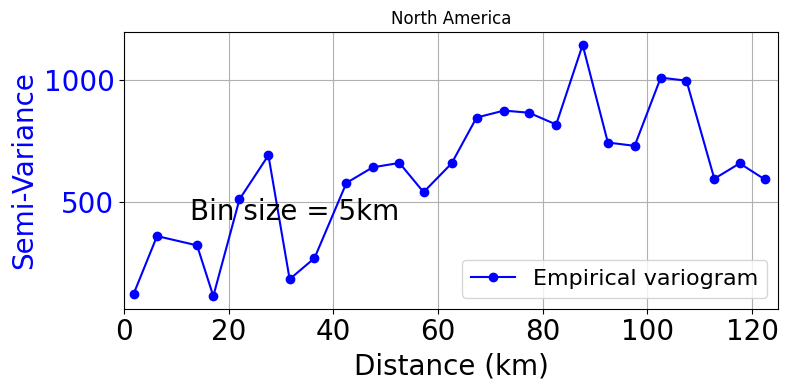

drop pseudo-zero points for South America (3199, 376)
[15:13:03] start calculating distance and difference matrix
[15:13:03] finish
[15:13:04] start binning
[15:13:04] finish binning for bin size 5 km
model  nugget,   sill,   range
exponential [205.46957443 712.52365625   5.90547772]
spherical [  1.14604784 688.75509254   1.02835202]
gaussian [1.79800675e+00 6.88755093e+02 3.38866351e-01]


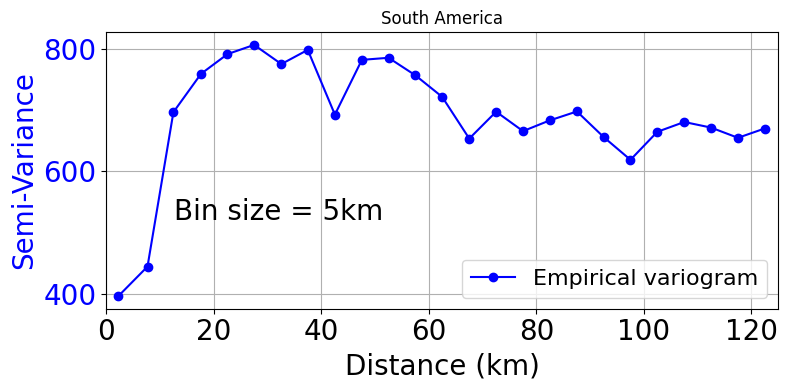

drop pseudo-zero points for Africa (2773, 376)
[15:13:04] start calculating distance and difference matrix
[15:13:05] finish
[15:13:05] start binning
[15:13:05] finish binning for bin size 5 km
model  nugget,   sill,   range
exponential [1.20985573e+03 1.02389609e+02 4.21741675e-01]
spherical [ 14.0676747  103.41846722   1.57981731]
gaussian [159.47599575 102.38960369   1.77315367]


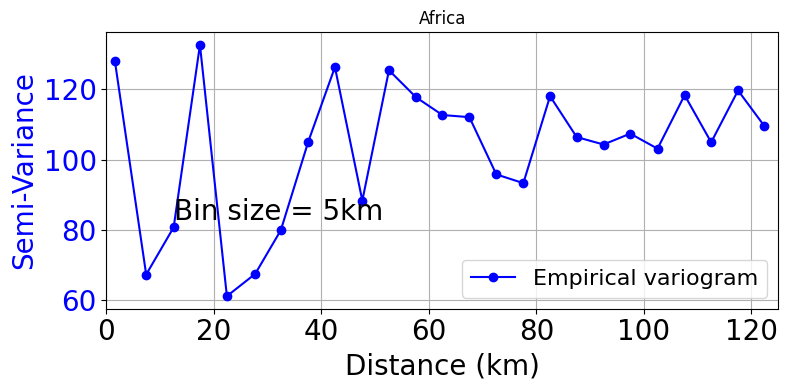

drop pseudo-zero points for Asia (812, 376)
[15:13:06] start calculating distance and difference matrix
[15:13:06] finish
[15:13:06] start binning
[15:13:06] finish binning for bin size 5 km
model  nugget,   sill,   range
exponential [7.16351635e+01 3.85633286e+05 3.78660667e+05]
spherical [9.15519663e-14 1.46446088e+02 2.36656167e+01]
gaussian [  9.52322529 147.21746917  11.84916898]


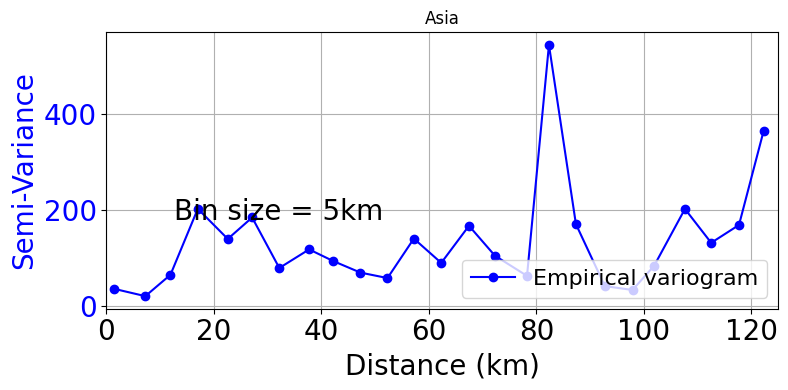

drop pseudo-zero points for Europe (10712, 376)
[15:13:06] start calculating distance and difference matrix
[15:13:10] finish
[15:13:22] start binning
[15:13:22] finish binning for bin size 5 km
model  nugget,   sill,   range
exponential [285.78316284 444.49386147  26.00123409]
spherical [  1.02927445 411.82843528   1.2863137 ]
gaussian [  1.85593716 411.82843528   0.45548944]


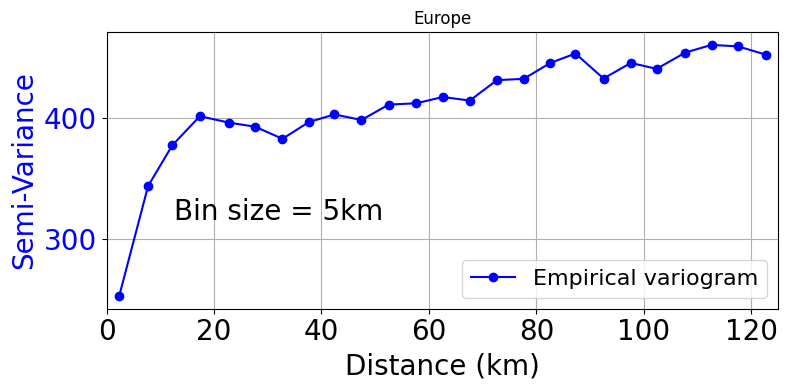

drop pseudo-zero points for Oceania (1258, 376)
[15:13:22] start calculating distance and difference matrix
[15:13:23] finish
[15:13:23] start binning
[15:13:23] finish binning for bin size 5 km
model  nugget,   sill,   range
exponential [3.34984127e+00 4.02378072e+02 5.29725350e-04]
spherical [  2.67190409 402.37755992   0.66071284]
gaussian [4.37909685e+00 4.02377560e+02 3.18320962e-01]


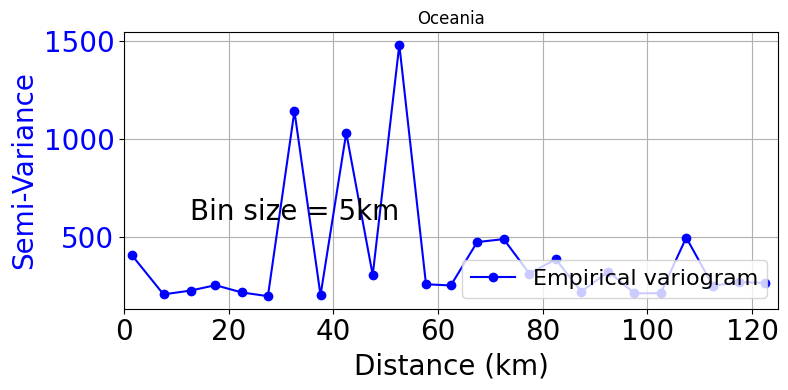

In [6]:
ts = 125 # truncated distance in km

for ctn in ['North America', 'South America', 'Africa', 'Asia', 'Europe', 'Oceania']:
    pseudo = 0
    dfc = dfv.loc[dfv['continent']==ctn].copy()
    dfc = dfc.to_crs(continent_proj_epsg.get(ctn))
    if pseudo:
        print(f'keep pseudo-zero points for {ctn}', dfc.shape) 
    else:
        dfc = dfc.loc[dfc['source_db']!='GLanCE.points']
        print(f'drop pseudo-zero points for {ctn}', dfc.shape)
        
    # calculate dist and diff matrix
    coords = np.array([[geom.x, geom.y] for geom in dfc.geometry])
    values = dfc['err'].to_numpy()
    ttprint('start calculating distance and difference matrix')
    dist_matrix = distance_matrix(coords, coords) / 1000   # pairwise distance
    diff_matrix = (values[:, None] - values[None, :]) ** 2    # pairwise difference
    ttprint('finish')
    # Extract upper triangular part (excluding diagonal)
    i, j = np.triu_indices(len(dfc), k=1)
    all_dists = dist_matrix[i, j]
    all_diffs = diff_matrix[i, j]
    # re-organize them in a sorted way
    sort_idx = np.argsort(all_dists)
    all_dists = all_dists[sort_idx]
    all_diffs = all_diffs[sort_idx]
    
    # do the binning for 200km
    mask_vc = all_dists <= 200  # variogram calculting distance, in km
    all_dists_filt = all_dists[mask_vc]
    all_diffs_filt = all_diffs[mask_vc]
    ttprint('start binning')
    bins_size = 5 # unit=km
    binned_dist, binned_variogram, bin_center, binned_number = bin_semivar(all_dists_filt, all_diffs_filt, bins_size)
    ttprint(f'finish binning for bin size {bins_size} km')

    # fit the theoretical variogram
    mask_tc = binned_dist <= ts 
    filtered_distances = binned_dist[mask_tc]
    filtered_variograms = binned_variogram[mask_tc]  
    # y = correlation_function(distance, *params_exponential)
    params_spherical = fit_variogram_model(spherical_model, filtered_distances, filtered_variograms)
    params_exponential = fit_variogram_model(exponential_model, filtered_distances, filtered_variograms)
    params_gaussian = fit_variogram_model(gaussian_model, filtered_distances, filtered_variograms)
    print('model  nugget,   sill,   range')
    print('exponential', params_exponential)
    print('spherical', params_spherical)
    print('gaussian', params_gaussian)
    # illustrate the theoretical one
    h_vals = np.linspace(0, ts, 200)
    fitted_variogram_spherical = spherical_model(h_vals, *params_spherical)
    fitted_variogram_exponential = exponential_model(h_vals, *params_exponential)
    fitted_variogram_gaussian = gaussian_model(h_vals, *params_gaussian)
    # print('------------------------------------------------------------------')
    
    # visualize
    fig, ax1 = plt.subplots(figsize=(8,4))

    ax1.plot(filtered_distances, filtered_variograms, marker='o', linestyle='-', color='b', label='Empirical variogram')
    ax1.set_xlabel('Distance (km)', fontsize=20)
    ax1.set_title(ctn)
    # if pseudo:
    #     ax1.set_title(f'With pseudo-zero points, {ctn}', fontsize=20)
    # else:
    #     ax1.set_title(f'Without pseudo-zero points, {ctn}', fontsize=20)

    ax1.set_ylabel('Semi-Variance', color='b', fontsize=20)
    ax1.tick_params(axis='y', labelcolor='b', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    # ax1.text(0.1, 0.4, f'Bin size = {bins_size}km', 
                # ha='left', va='top', transform=ax1.transAxes, fontsize=20)  


    # ax1.plot(h_vals, fitted_variogram_exponential, linestyle='--', color='r', label='Exponential Model')
    # ax1.plot(h_vals, fitted_variogram_spherical, linestyle='--', color='g', label='Spherical Model')
    # ax1.plot(h_vals, fitted_variogram_gaussian, linestyle='--', color='c', label='Gaussian Model')
    # plt.title('Germany', fontsize=20)
    ax1.grid(True)
    ax1.set_xlim([0,ts])
    # ax1.set_ylim([-1,2])
    fig.tight_layout()  
    # plt.legend(fontsize=16, loc='lower right')
    plt.show()


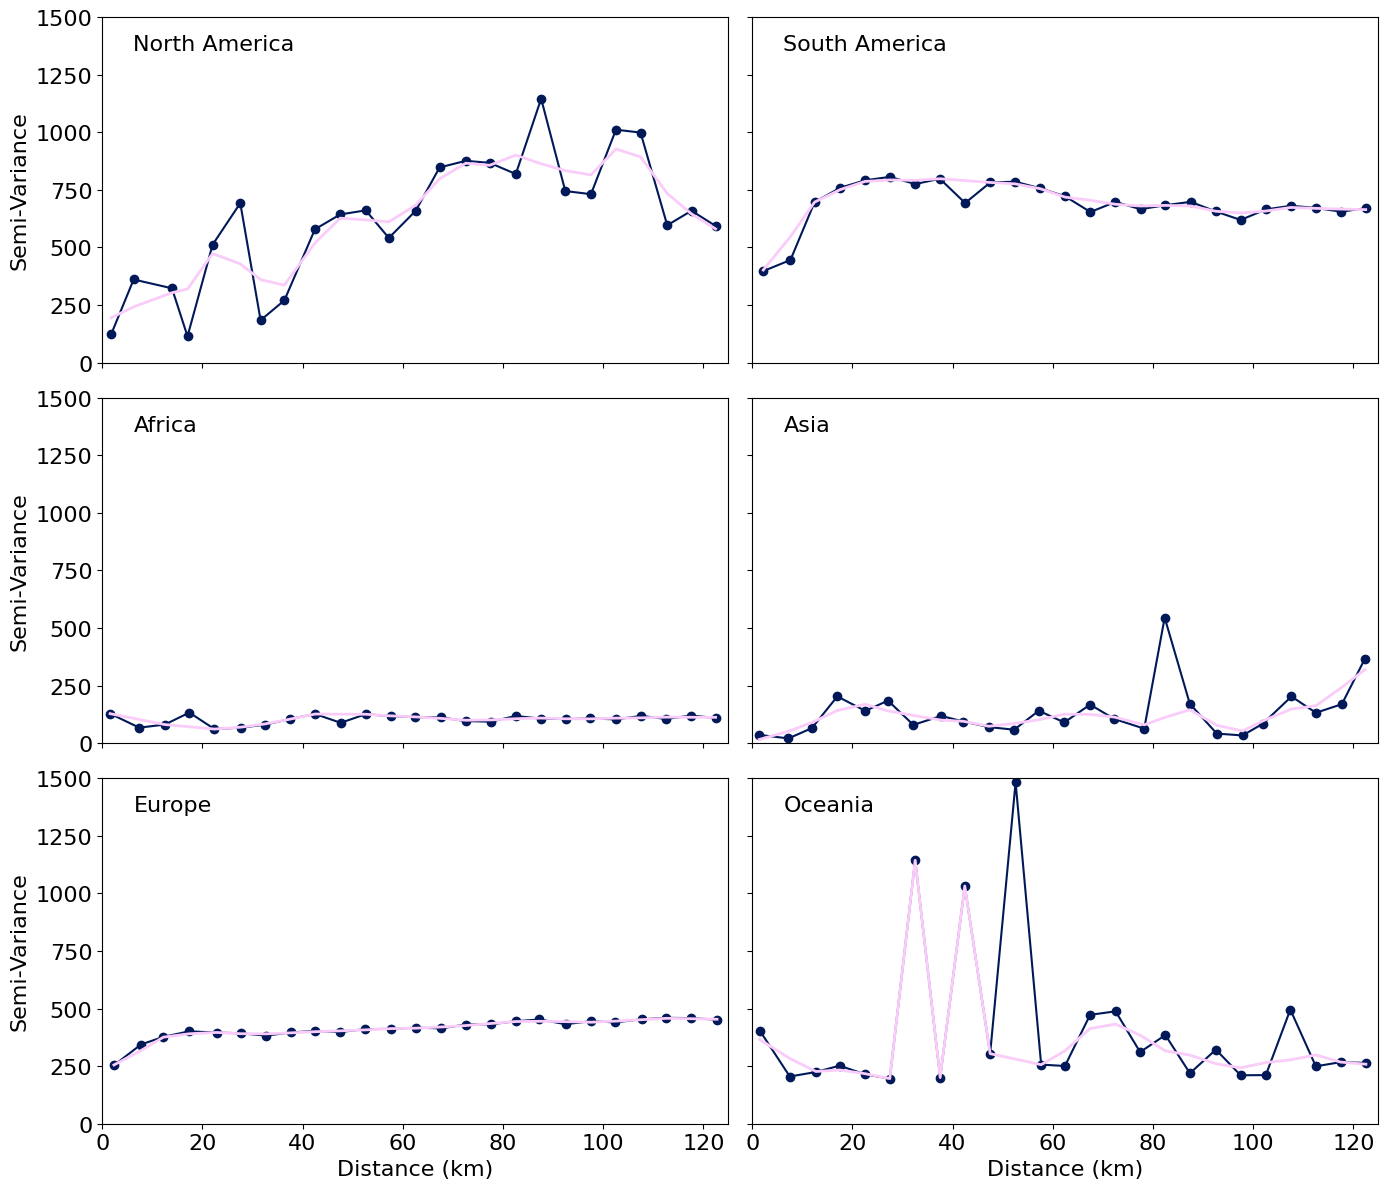

In [26]:
from statsmodels.nonparametric.smoothers_lowess import lowess

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, ctn in enumerate(['North America', 'South America', 'Africa', 'Asia', 'Europe', 'Oceania']):
    pseudo = 0
    dfc = dfv.loc[dfv['continent'] == ctn].copy()
    dfc = dfc.to_crs(continent_proj_epsg.get(ctn))
    if not pseudo:
        dfc = dfc.loc[dfc['source_db'] != 'GLanCE.points']

    coords = np.array([[geom.x, geom.y] for geom in dfc.geometry])
    values = dfc['err'].to_numpy()
    dist_matrix = distance_matrix(coords, coords) / 1000
    diff_matrix = (values[:, None] - values[None, :]) ** 2
    i, j = np.triu_indices(len(dfc), k=1)
    all_dists = dist_matrix[i, j]
    all_diffs = diff_matrix[i, j]
    sort_idx = np.argsort(all_dists)
    all_dists = all_dists[sort_idx]
    all_diffs = all_diffs[sort_idx]

    mask_vc = all_dists <= 200
    all_dists_filt = all_dists[mask_vc]
    all_diffs_filt = all_diffs[mask_vc]
    binned_dist, binned_variogram, bin_center, binned_number = bin_semivar(all_dists_filt, all_diffs_filt, 5)

    mask_tc = binned_dist <= ts
    filtered_distances = binned_dist[mask_tc]
    filtered_variograms = binned_variogram[mask_tc]
    params_spherical = fit_variogram_model(spherical_model, filtered_distances, filtered_variograms)
    h_vals = np.linspace(0, ts, 200)
    fitted_variogram_spherical = spherical_model(h_vals, *params_spherical)

    ax = axes[idx]
    ax.plot(filtered_distances, filtered_variograms, marker='o', linestyle='-', color='#011959') #, label='Empirical'
    smoothed = lowess(filtered_variograms, filtered_distances, frac=0.2)
    ax.plot(smoothed[:, 0], smoothed[:, 1], color='#faccfa', linewidth=2, label='Smoothed')
    # ax.plot(smoothed[:, 0], smoothed[:, 1], color='orange', linewidth=2, label='Smoothed')
    # ax.plot(h_vals, fitted_variogram_spherical, linestyle='--', color='g', label='Spherical')
    
    # Title inside plot
    ax.text(0.05, 0.95, ctn, transform=ax.transAxes, fontsize=16, va='top', ha='left')
    # if idx not in [1,2]:
    #     ax.text(0.05, 0.95, ctn, transform=ax.transAxes, fontsize=16, va='top', ha='left')
    # else:
    #     ax.text(0.68, 0.15, ctn, transform=ax.transAxes, fontsize=16, va='top', ha='left')
    
    # Y-axis labels only for left column (i.e., col 0)
    if idx % 2 == 0:
        ax.set_ylabel('Semi-Variance', fontsize=16)
    else:
        ax.set_yticklabels('')

    # X-axis labels only for bottom row (i.e., row 2)
    if idx // 2 == 2:
        ax.set_xlabel('Distance (km)', fontsize=16)
    else:
        ax.set_xticklabels('')

    ax.tick_params(axis='both', labelsize=16)
    ax.grid(False)
    ax.set_xlim([0, ts])
    ax.set_ylim([0, 1500])

fig.tight_layout()
fig.savefig("Fig_variogram_continents.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()
